## Initialization

In [3]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
import os
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [375]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [376]:
#TESS Central camera coordinates for each sector in RA, Dec
sector_coordinates = np.load('tess_dat/sector_coordinates.npy', allow_pickle=True).item()

#Number of sources in each sector
sector_sources = np.load('tess_dat/sector_sources.npy', allow_pickle=True).item()


In [378]:
#Convert to galactic coordinates
sector_coordinates_galactic = {}

def get_galactic_coords(ra, dec):
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    galactic_coord = coord.galactic
    return galactic_coord.l.degree, galactic_coord.b.degree

for sector in sector_coordinates.keys():
    ra, dec = sector_coordinates[sector]
    sector_coordinates_galactic[sector] = get_galactic_coords(ra, dec)

In [379]:
def tess_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of TESS
    #Need to replace this eventually. Assume perfect efficiency for now
    '''
    return 1.0


In [387]:
def write_survey_params():
    survey_params_dict = {}

    for sector in sector_sources.keys():
        l, b = sector_coordinates_galactic[int(sector)]
        if int(sector) <= 26:
            cadence = 30/60
        elif int(sector) >= 27 and int(sector) <= 55:
            cadence = 10/60
        else:
            cadence = 3.3/60
        survey_params_dict[sector] = {"l": l, "b": b, "source_dist": 1.5, "obs_time": 27.4*24, "cadence": cadence, "survey_area": 1.5, "n_sources": sector_sources[sector], "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01}
    return survey_params_dict

survey_params_dict = write_survey_params()

In [8]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr]

    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    if not s.use_mw_source:
        ax.plot(d_arr, rho_ffp_m31, label="M31 UBOs")
        ax.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    if s.use_mw_source:
        ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)
    else:
        ax.set_title(r'M31 Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e2, 1e10)


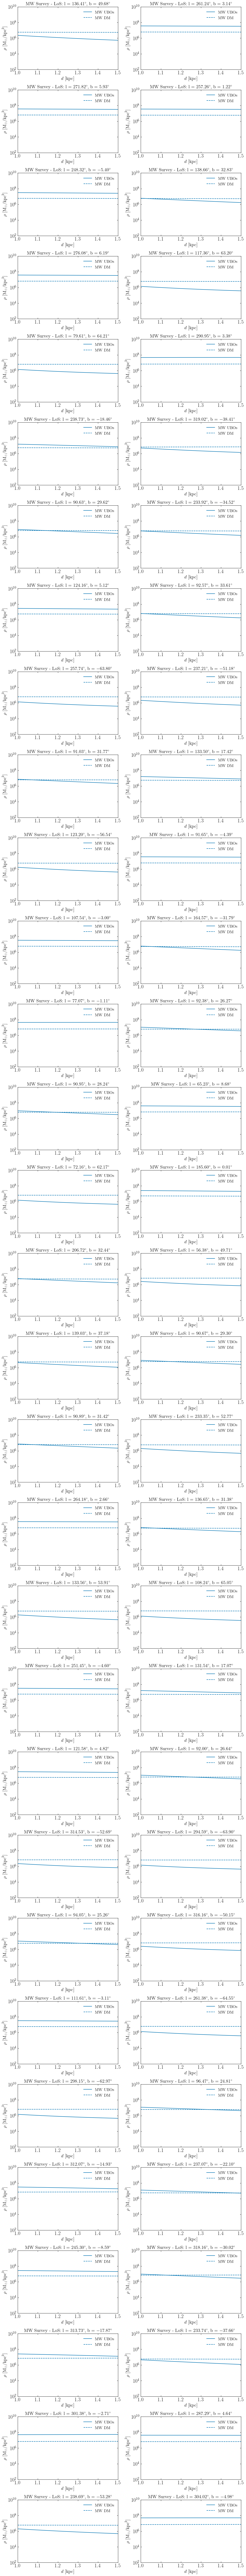

In [25]:
n_params = len(survey_params_dict)
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  

# Loop through the parameter sets and create subplots
for i, param_set in enumerate(survey_params_dict.values()):
    s = Survey(**param_set)
    ax = axes[i]
    plot_line_of_sight(s, ax)

plt.tight_layout()

In [381]:
#J-factor like metric to compare density of UBOs
def ubo_factor(s):
    #integrated density of UBOs along line of sight (not include finite size effects)
    d_arr = np.linspace(0, s.source_dist, 1000) #kpc
    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    
    rho_ffp_interp = interp1d(d_arr, rho_ffp_mw)

    return quad(rho_ffp_interp, 0, s.source_dist)[0] 

## FFPs

In [382]:
t_es = np.logspace(np.log10(3.3/60), np.log10(27.4*24), 30) #hours
ms = np.logspace(-12, -3, 30)

In [383]:
def get_n_events(s, p=1, finite=True):
    s.add_ffp(p)
    diff_rates_mw = np.array([s.ffp.differential_rate_mw_mass(m, finite=finite, efficiency=s.efficiency, tcad = s.cadence*2, tobs=s.obs_time) for m in ms])
    diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw))
    def diff_rates_interp(m):
        return 10**diff_rates_interp_log(np.log10(m))
    dnds = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]
    return s.n_sources*dnds*s.obs_time


In [12]:
# s1 = Survey(**survey_params_dict["1"])
s2 = Survey(**survey_params_dict["27"])
# s1.add_ffp(1)
s2.add_ffp(1)
# diff_rates_mw1 = np.array([s1.ffp.differential_rate_mw_mass(m, efficiency=s1.efficiency, tcad = s1.cadence*2, tobs=s1.obs_time) for m in ms])
diff_rates_mw2 = np.array([s2.ffp.differential_rate_mw_mass(m, efficiency=s2.efficiency, tcad = s2.cadence*2, tobs=s2.obs_time) for m in ms])


In [13]:
diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw2))
def diff_rates_interp(m):
    return 10**diff_rates_interp_log(np.log10(m))
dnds2 = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]

In [14]:
def gamma_of_m(m):
    return quad(diff_rates_interp, m*10**(-0.5), m*10**(0.5), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]

In [15]:
ms_limited = np.logspace(-11.5, -3.5, 100)
gamma_of_ms = np.array([gamma_of_m(m) for m in ms_limited])

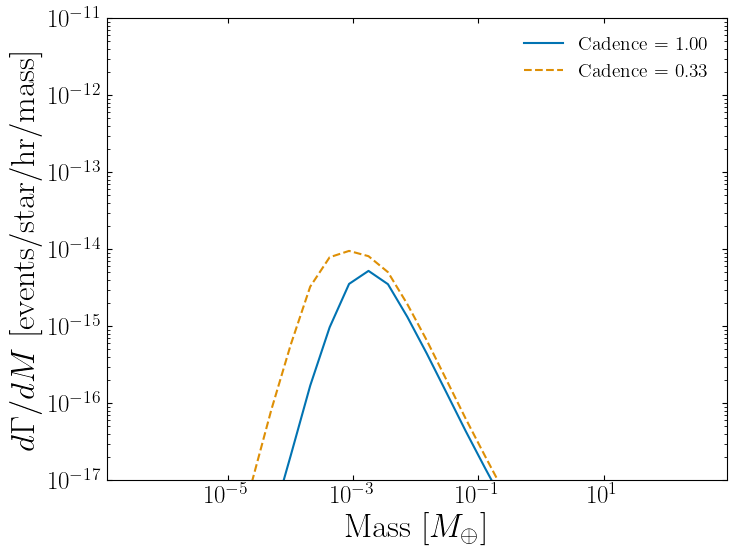

In [79]:
plt.plot(ms/3e-6, diff_rates_mw1, label=f"Cadence = {s1.cadence*2:.2f}")
plt.plot(ms/3e-6, diff_rates_mw2, label=f"Cadence = {s2.cadence*2:.2f}", ls='--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Mass [$M_\oplus$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]")

plt.ylim(1e-17, 1e-11)

plt.legend()
plt.show()

In [28]:
# np.savetxt("tess_dat/gamma_of_ms.csv", np.array([ms_limited/3e-6, gamma_of_ms/np.sum(gamma_of_ms)]).T)

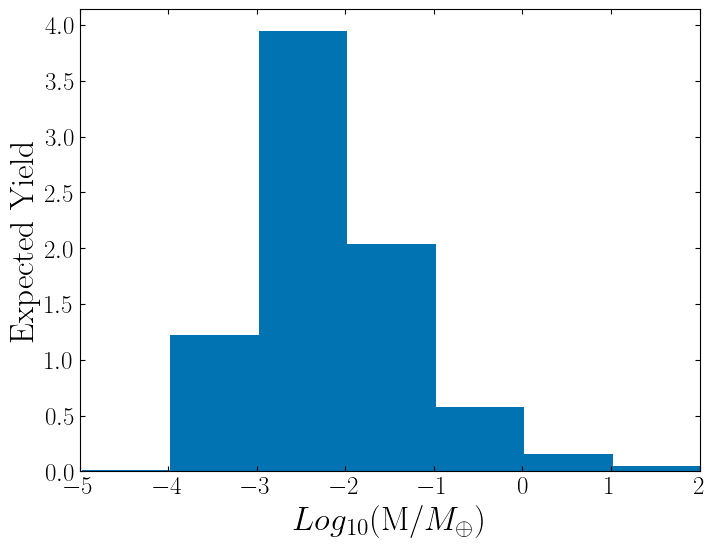

In [63]:
# plt.plot(ms_limited/3e-6, gamma_of_ms/np.sum(gamma_of_ms))
# plt.bar(np.log10(ms_limited/3e-6), gamma_of_ms/np.sum(gamma_of_ms), width=1)
plt.hist(np.log10(ms_limited/3e-6), weights=8*gamma_of_ms/np.sum(gamma_of_ms), bins=8, color="C0")

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$Log_{10}$(M/$M_\oplus$)")
# plt.ylabel(r"$\Gamma(M)/\Gamma_{\rm{tot}}$ [events/star/hr]")
plt.ylabel("Expected Yield")
plt.xlim(-5, 2)
# plt.ylim(1e-24, 1e-21)
# plt.ylim(1e-3, 2e-1)

# plt.savefig('figures/tess_mass_sensitivity.pdf')
# plt.savefig('figures/tess_yield_estimate.pdf')
plt.show()

In [66]:
diff_rates_t_1_finite = np.array([s1.ffp.differential_rate_mw(t, finite=True, v_disp=None, t_e=False) for t in tqdm(t_es)])
diff_rates_t_1_point = np.array([s1.ffp.differential_rate_mw(t, finite=False, v_disp=None, t_e=False) for t in tqdm(t_es)])

100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


In [83]:
diff_rates_t_interp_log = interp1d(np.log10(t_es), np.log10(diff_rates_t_1_finite))
def diff_rates_t_interp(t):
    return 10**diff_rates_t_interp_log(np.log10(t))

In [86]:
def gamma_of_t(t):
    return quad(diff_rates_t_interp, t*10**(-0.5), t*10**(0.5), epsabs=0, epsrel=1e-1)[0]

In [90]:
ts_limited = np.logspace(np.log10(3.3/60 * 10**(0.5)), np.log10(27.4*24 * 10**(-0.5)), 100)
gamma_of_ts = np.array([gamma_of_t(t) for t in ts_limited])

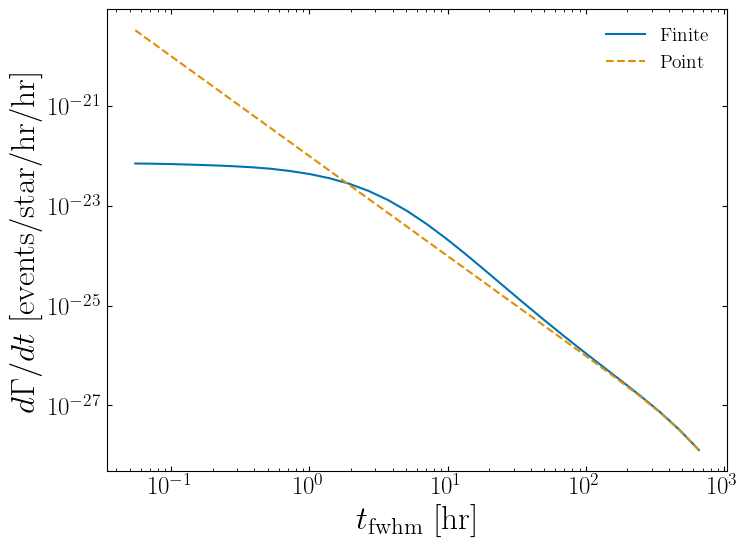

In [67]:
plt.plot(t_es, diff_rates_t_1_finite, label=f"Finite")
plt.plot(t_es, diff_rates_t_1_point, label=f"Point", ls='--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$t_{\rm{fwhm}}$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")

# plt.ylim(1e-17, 1e-11)

plt.legend()
plt.show()

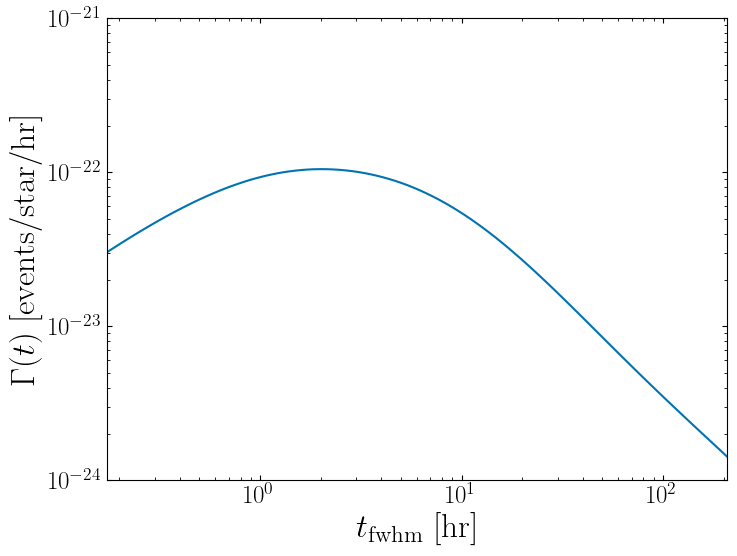

In [100]:
plt.plot(ts_limited, gamma_of_ts)

plt.axvline(3.3/60, ls='--', color='k')
plt.axvline(27.4*24, ls='--', color='k')

plt.xlim(min(ts_limited), max(ts_limited))
plt.ylim(1e-24, 1e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$t_{\rm{fwhm}}$ [hr]")
plt.ylabel(r"$\Gamma(t)$ [events/star/hr]")

plt.show()

In [11]:
def get_num_events_fiducial(s, finite=True):

    #power law, normalization, and normalization mass for fiducial mass function
    p = 1
    Z_fiducial = 10
    M_norm = 3e-6 #earth mass in solar mass units

    #number of events for a power law normalized to 1 UBO per star total
    n_events = get_n_events(s, p=p, finite=finite)

    #rescale normalization of pdf to M_norm = earth mass if not already
    z_earth = s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p) 

    #number of objects per star for fiducial mass function at 1 earth mass

    num_events_fiducial = n_events * Z_fiducial/z_earth

    return num_events_fiducial

In [12]:
def compute_expected_num_events(survey_name_and_params):
    survey_name, param_set = survey_name_and_params
    s = Survey(**param_set)
    expected_num_events_finite = get_num_events_fiducial(s, finite=True)
    expected_num_events_point = get_num_events_fiducial(s, finite=False)
    return survey_name, expected_num_events_finite, expected_num_events_point

survey_name_and_params_list = [(survey_name, params) for survey_name, params in survey_params_dict.items()]

with Pool() as pool:
    results = list(tqdm(pool.imap(compute_expected_num_events, survey_name_and_params_list), total=len(survey_name_and_params_list)))


100%|██████████| 62/62 [33:24<00:00, 32.32s/it]  


In [18]:
num_events_dict = {}
num_events_point_dict = {}

for survey_name, expected_num_events_finite, expected_num_point_events in results:
    num_events_dict[survey_name] = expected_num_events_finite
    num_events_point_dict[survey_name] = expected_num_point_events

In [19]:
ubo_factor_dict = {}
for i, survey_name in enumerate(survey_params_dict.keys()):
    param_set = survey_params_dict[survey_name]
    s = Survey(**param_set)
    ubo_factor_dict[survey_name] = ubo_factor(s)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_51131/3079570761.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(rho_ffp_interp, 0, s.source_dist)[0]


In [20]:
# Create a list of dictionaries for the table
table_data = []
for survey_name, param_set in survey_params_dict.items():
    row = {
        "Survey": survey_name,
        "l": param_set["l"],
        "b": param_set["b"],
        "n_sources": param_set["n_sources"],
        "ubo_factor": ubo_factor_dict[survey_name],
        "obs_time": param_set["obs_time"],
        # "num_expected_events_tot": num_events_dict[survey_name],
        "N/h finite": float(num_events_dict[survey_name]) / float(param_set["obs_time"]),
        # "num_expected_events_point_tot": num_events_point_dict[survey_name],
        "N/h point": float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]),
        "finite_factor": (float(num_events_dict[survey_name]) / float(param_set["obs_time"]))/(float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]))

    }
    table_data.append(row)

df = pd.DataFrame(table_data)
df = df[["Survey", "l", "b", "n_sources", "ubo_factor", "obs_time", "N/h finite", "N/h point", "finite_factor"]]


In [21]:
# Define a function to format large numbers in scientific notation
def scientific_format(x):
    return '{:.4e}'.format(x)

# Apply styling to the DataFrame
styled_df = (
    df.style
    .format({
        'l': '{:.1f}',
        'b': '{:.1f}',
        'n_sources': '{:.1e}',
        'ubo_factor': '{:.1e}',
        'obs_time': '{:.1f}',
        # 'num_expected_events_tot': '{:.1e}',
        'N/h finite': '{:.1e}',
        # 'num_expected_events_point_tot': '{:.1e}',
        'N/h point': '{:.1e}',
        'finite_factor': '{:.1e}',
        
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
    .set_caption('Survey Parameters and Expected Events')
)

styled_df


,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
0,21,136.4,49.7,3.5e+05,1.8e+07,657.6,4.5e-07,3.7e-07,1.2e+00
1,35,261.2,3.1,1.1e+06,5.7e+07,657.6,5.0e-06,2.4e-05,2.1e-01
2,9,271.8,5.9,1.2e+06,5.8e+07,657.6,4.8e-06,8.7e-06,5.5e-01
3,8,257.3,1.2,1.2e+06,5.6e+07,657.6,4.6e-06,8.4e-06,5.5e-01
4,34,248.3,-5.4,1.3e+06,5.1e+07,657.6,5.3e-06,2.4e-05,2.2e-01
5,20,138.7,32.8,5.4e+05,2.4e+07,657.6,9.4e-07,9.5e-07,9.9e-01
6,36,276.1,6.2,1.2e+06,5.9e+07,657.6,5.7e-06,2.7e-05,2.1e-01
7,22,117.4,63.2,3.0e+05,1.6e+07,657.6,3.3e-07,2.5e-07,1.3e+00
8,23,79.6,64.2,3.1e+05,1.6e+07,657.6,3.5e-07,2.6e-07,1.3e+00
9,37,290.9,3.4,1.6e+06,6.8e+07,657.6,8.4e-06,4.4e-05,1.9e-01


In [22]:
df.sort_values(by="N/h finite", ascending=False)

,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
61,38,304.015069,-4.982319,2017423,7.127044e+07,657.6,1.112640e-05,5.880797e-05,0.189199
52,12,312.071468,-14.931531,2857972,5.239483e+07,657.6,1.099066e-05,1.762349e-05,0.623637
58,11,301.382739,-2.713255,2111868,7.305856e+07,657.6,1.066943e-05,2.168775e-05,0.491956
56,39,313.734112,-17.869120,2619851,4.678361e+07,657.6,1.051067e-05,3.936883e-05,0.266979
27,54,65.228332,8.684376,1946592,6.121161e+07,657.6,9.533537e-06,4.558957e-05,0.209117
...,...,...,...,...,...,...,...,...,...
0,21,136.406300,49.676537,350200,1.823455e+07,657.6,4.485973e-07,3.672894e-07,1.221373
50,2,298.145728,-62.970482,379332,1.679713e+07,657.6,4.362120e-07,3.312015e-07,1.317059
8,23,79.613608,64.211895,311543,1.642296e+07,657.6,3.482488e-07,2.620756e-07,1.328811
7,22,117.364762,63.204522,303773,1.614901e+07,657.6,3.329003e-07,2.501917e-07,1.330581


In [23]:
df.sort_values(by="n_sources", ascending=False)

,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
52,12,312.071468,-14.931531,2857972,5.239483e+07,657.6,1.099066e-05,1.762349e-05,0.623637
56,39,313.734112,-17.869120,2619851,4.678361e+07,657.6,1.051067e-05,3.936883e-05,0.266979
58,11,301.382739,-2.713255,2111868,7.305856e+07,657.6,1.066943e-05,2.168775e-05,0.491956
61,38,304.015069,-4.982319,2017423,7.127044e+07,657.6,1.112640e-05,5.880797e-05,0.189199
27,54,65.228332,8.684376,1946592,6.121161e+07,657.6,9.533537e-06,4.558957e-05,0.209117
...,...,...,...,...,...,...,...,...,...
16,30,257.744145,-63.799651,346791,1.623058e+07,657.6,5.248807e-07,8.940161e-07,0.587104
39,49,108.236383,65.047411,346231,1.601694e+07,657.6,5.167360e-07,8.718453e-07,0.592692
8,23,79.613608,64.211895,311543,1.642296e+07,657.6,3.482488e-07,2.620756e-07,1.328811
7,22,117.364762,63.204522,303773,1.614901e+07,657.6,3.329003e-07,2.501917e-07,1.330581


In [29]:
print("total events finite: " + str((df['N/h finite'] * df['obs_time']).sum()))
print("total events point: " + str((df['N/h point'] * df['obs_time']).sum()))


total events finite: 0.12970029219887927
total events point: 0.5918285497885327


In [31]:
# Define a function to format large numbers in scientific notation
def scientific_format(x):
    return '{:.4e}'.format(x)

# Apply styling to the DataFrame
styled_df = (
    df.style
    .format({
        'l': '{:.1f}',
        'b': '{:.1f}',
        'n_sources': '{:.1e}',
        'ubo_factor': '{:.1e}',
        'obs_time': '{:.1f}',
        # 'num_expected_events_tot': '{:.1e}',
        'N/h finite': '{:.1e}',
        # 'num_expected_events_point_tot': '{:.1e}',
        'N/h point': '{:.1e}',
        'finite_factor': '{:.1e}',
        
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
    .set_caption('Survey Parameters and Expected Events')
)

styled_df
#! WHy doesn't ubo_factor seem to matter much?



,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
0,tess_1_1,12.5,-48.2,1.2e+05,2.2e+07,657.6,3.8e-07,3.8e-07,1.0e+00
1,tess_1_2,335.0,-52.6,1.2e+05,2.0e+07,657.6,3.2e-07,3.2e-07,1.0e+00
2,tess_1_3,300.0,-45.0,1.2e+05,2.2e+07,657.6,3.8e-07,3.8e-07,1.0e+00
3,tess_1_4,276.4,-29.8,1.2e+05,3.0e+07,657.6,6.4e-07,6.4e-07,1.0e+00
4,tess_27_1,2.1,-30.5,1.6e+05,3.5e+07,657.6,2.3e-06,2.3e-06,1.0e+00
5,tess_27_2,334.2,-37.6,1.6e+05,2.8e+07,657.6,1.7e-06,1.7e-06,1.0e+00
6,tess_27_3,303.9,-37.3,1.6e+05,2.6e+07,657.6,1.6e-06,1.6e-06,1.0e+00
7,tess_max_cad_test,276.4,-29.8,1.6e+05,3.0e+07,657.6,2.7e-06,2.7e-06,1.0e+00


## PBH Estimates

In [384]:
s = Survey(**survey_params_dict["27"])
s.add_pbh(1e-5)
print(s.pbh.rate_tot(finite=True)) #num events per hour observed per source
print(s.n_sources * s.pbh.rate_tot(finite=True) * s.obs_time) #total number of events observed

5.736819380728697e-10
0.2391106501465941


In [388]:
def get_n_events_pbh(m, finite=True):
    s.add_pbh(m)
    dnds = s.pbh.rate_mw(finite=finite, tcad= s.cadence, tobs= s.obs_time) #! Need to add t_cad and t_obs to rate_mw here
    # return s.n_sources*s.efficiency*dnds*s.obs_time
    return s.n_sources* 1 *dnds*s.obs_time

def get_constraint_fdm(m, finite=True):
    n_events = get_n_events_pbh(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_n_events_pbh_s(survey_name_and_params, finite=True):
    #Get the number of events for monochromatic pbh spectrum for each value of m
    survey_name, param_set = survey_name_and_params
    s = Survey(**param_set)
    n_events_ms = []
    for m in ms:
        s.add_pbh(m)
        dnds = s.pbh.rate_mw(finite=finite, tcad= s.cadence, tobs= s.obs_time) #! Need to add t_cad and t_obs to rate_mw here
        n_events_ms.append(s.n_sources* 1 *dnds*s.obs_time)
    n_events_ms = np.array(n_events_ms)
    return n_events_ms


In [389]:
survey_name_and_params_list = [(survey_name, params) for survey_name, params in survey_params_dict.items()]

with Pool() as pool:
    results_pbh = np.array(list(tqdm(pool.imap(get_n_events_pbh_s, survey_name_and_params_list), total=len(survey_name_and_params_list))))

 16%|█▌        | 10/62 [01:49<08:54, 10.28s/it]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 52%|█████▏    | 32/62 [03:45<02:34,  5.13s/it]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r 

In [ ]:
num_events_pbh_dict = {}
num_events_point_dict = {}

for survey_name, expected_num_events_finite, expected_num_point_events in results_pbh:
    num_events_dict[survey_name] = expected_num_events_finite
    num_events_point_dict[survey_name] = expected_num_point_events

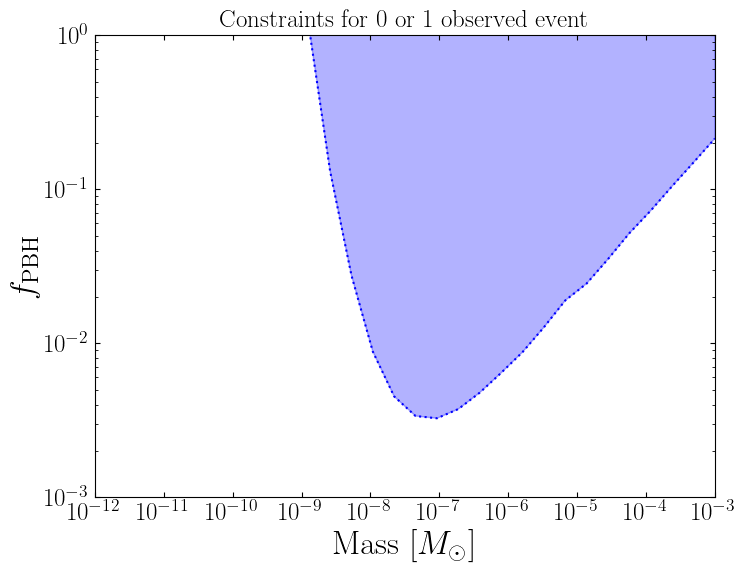

In [394]:
plt.loglog(ms, 4.47/np.sum(results_pbh, axis=0), 'blue', ls=':')
plt.fill_between(ms, 4.47/np.sum(results_pbh, axis=0), 1e10, alpha=0.3, color='blue')

plt.xlim(min(ms), max(ms))
plt.ylim(1e-3, 1e0)

plt.xlabel(r'Mass [$M_{\odot}$]')
plt.ylabel(r'$f_{\rm{PBH}}$')
plt.title('Constraints for 0 or 1 observed event')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))


plt.show()

### Old

In [40]:
#this is for 1 survey and LoS so constraints would be stronger than this. Also for 0 or 1 observed event
fdms = np.array([get_constraint_fdm(m, finite=True) for m in ms])

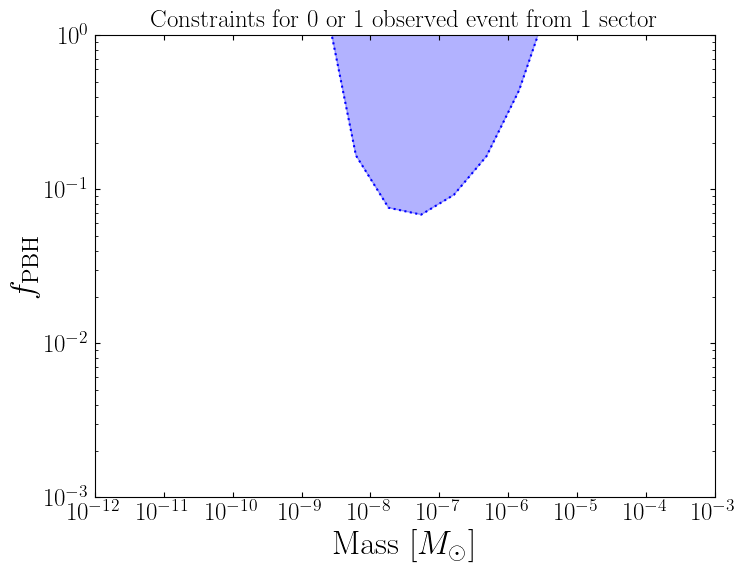

In [54]:
ms_earth = ms/3e-6
plt.loglog(ms, fdms, 'blue', ls=':')
plt.fill_between(ms, fdms, 1e10, alpha=0.3, color='blue')

plt.xlim(min(ms), max(ms))
plt.ylim(1e-3, 1e0)

plt.xlabel(r'Mass [$M_{\odot}$]')
plt.ylabel(r'$f_{\rm{PBH}}$')
plt.title('Constraints for 0 or 1 observed event from 1 sector')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))


plt.show()

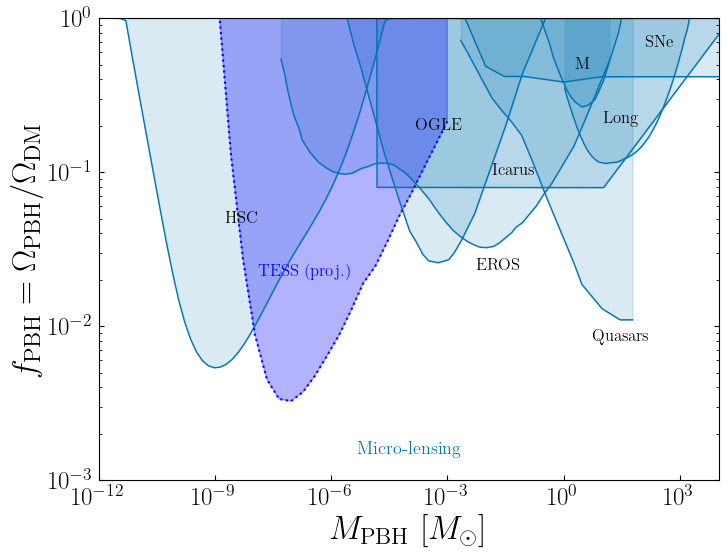

In [433]:
#General options
plot_SGWB_range = True

#Default values, overridden if you pass in command line arguments
# listfile_default = "listfiles/bounds_microlensing.txt" 
outfile_default = "plots/PBHbounds_microlensing_square.pdf"

listfile= 'bounds_microlensing.txt'
outfile = outfile_default

alpha_val = 0.15

bounds = np.loadtxt(listfile, usecols=(0,), dtype=str)
colors = np.loadtxt(listfile, usecols=(1,), dtype=str)
lines = np.loadtxt(listfile, usecols=(2,), dtype=str)
xlist = np.loadtxt(listfile, usecols=(3,))
ylist = np.loadtxt(listfile, usecols=(4,))
anglist = np.loadtxt(listfile, usecols=(5,))
labellist = np.loadtxt(listfile, usecols=(6,), dtype=str)

Mgrid = np.geomspace(1e-12, 1e5, 1000)
envelope = 1.0 + 0.0*Mgrid

def addConstraint(boundID, col='blue',x = 1e-30,y=1e-4,ang=0, linestyle='-', labeltext=''):
    m, f = np.loadtxt('bounds/' + boundID + '.txt', unpack=True)
    if (boundID != "OGLE-hint"):
        plt.fill_between(m , np.clip(f, 0,1), 1, alpha=alpha_val, color=col)
    linewidth = 1.0
    if (boundID in ["Microlensing", "Evaporation"]):
        linewidth=2.0
    plt.plot(m, np.clip(f, 0,1), color=col, lw=linewidth, linestyle=linestyle)
    
    if (x > 1e-20):
        plt.text(x, y, labeltext.replace("_", " "), rotation=ang, fontsize=12, ha='center', va='center')
        
    interped_lim = np.interp(Mgrid, m, np.clip(f, 0,1), left=1, right=1)
    envelope[interped_lim < envelope] = interped_lim[interped_lim < envelope]
    

def addSIGWprojections(col='red', linestyle='--'):
    plt.fill_between([6.6e-14, 6.6e-12], 5e-3, 1, color=col, alpha = alpha_val, linewidth=0)
    #plt.plot([6.6e-14, 6.6e-12], [3e-3, 3e-3], 0, color='red', linestyle='--')
    plt.plot([6.6e-14, 6.6e-14], [5e-3, 1], color = col, linestyle=linestyle, lw=1.0)
    plt.plot([6.6e-12, 6.6e-12], [5e-3, 1], color = col, linestyle=linestyle, lw=1.0)
    plt.text(8e-13, 7e-3, "LISA",fontsize=12, ha='center', va='bottom', rotation = 90)

    #AI/DECIGO
    plt.fill_between([1e-17, 1e-15], 5e-3, 1, color=col, alpha = alpha_val, linewidth=0)
    plt.plot([1e-17, 1e-17], [5e-3, 1], color = col, linestyle=linestyle, lw=1.0)
    plt.plot([1e-15, 1e-15], [5e-3, 1], color = col, linestyle=linestyle, lw=1.0)
    #plt.plot([1e-17, 1e-15], [3e-3, 3e-3], 0, color='red', linestyle='--')
    plt.text(1e-16, 7e-3, "DECIGO/AI",fontsize=12, ha='center', va='bottom', rotation = 90)
    
    plt.text(1e-14, 4e-3, "SIGWs", fontsize=12, ha='center', va='center')

#-------------------------------------------    
    
    
plt.figure(figsize=(8,6))

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.tick_bottom()
ax.xaxis.set_tick_params(pad=5)

for i in range(len(bounds)):  
    if (bounds[i] == "SIGWs"):
        addSIGWprojections(col=colors[i], linestyle=lines[i])
    else:
        addConstraint(bounds[i], col = colors[i], x = xlist[i], y = ylist[i], ang=anglist[i], linestyle=lines[i], labeltext=labellist[i])



#Plotting stuff
plt.axhspan(1, 1.5, facecolor='grey', alpha=0.5)
    
plt.ylim(1e-3, 1)

xmin = 1e-12
xmax = 1e4
plt.xlim(xmin, xmax)

ticks_minor = np.geomspace(1e-18, 1e4, 23)
ticks_minor = ticks_minor[(xmin <= ticks_minor) & (ticks_minor <= xmax)]
#print(ticks_minor)
ax.set_xticks(ticks_minor,minor=True)
ax.set_xticklabels([], minor=True)
    
ax.set_xlabel(r'$M_\mathrm{PBH}$ [$M_\odot$]')
plt.ylabel(r'$f_\mathrm{PBH} = \Omega_\mathrm{PBH}/\Omega_\mathrm{DM}$')

# ax_top = ax.twiny()
# ax_top.xaxis.tick_top()
# ax_top.set_xscale('log')
# ax_top.set_xlim(ax.get_xlim())
# ax_top.set_xlabel(r'$M_\mathrm{CO}$ [g]', labelpad=7)

g_to_Msun = 1/1.989e+33

g_ticks_minor = np.geomspace(1e15, 1e37, 23)
g_ticks_minor = g_ticks_minor[(xmin < g_to_Msun*g_ticks_minor) & (g_to_Msun*g_ticks_minor < xmax)]
g_ticks = g_ticks_minor[::3]


# g_tick_labels = [r"$10^{" + str(int(np.log10(x))) +"}$" for x in g_ticks]

# ax_top.set_xticks(g_ticks*g_to_Msun)
# ax_top.set_xticklabels(g_tick_labels)
# ax_top.xaxis.set_tick_params(pad=0)

# ax_top.set_xticks(g_ticks_minor*g_to_Msun,minor=True)
# ax_top.set_xticklabels([],minor=True)

ax.text(0.5, 0.05, "Micro-lensing", va = "bottom", ha = "center", color='C0',  transform=ax.transAxes)

plt.loglog(ms, 4.47/np.sum(results_pbh, axis=0), 'blue', ls=':')
plt.fill_between(ms, 4.47/np.sum(results_pbh, axis=0), 1, alpha=0.3, color='blue')
plt.text(2e-7, 2e-2, "TESS (proj.)",fontsize=12, ha='center', va='bottom', rotation = 0, color='blue')


# plt.savefig(outfile, bbox_inches='tight')
    
    
#Save envelope to file
headertxt = "Envelope of microlensing bounds: " + ", ".join(bounds)
headertxt += "\n Columns: PBH mass [Muns], PBH fraction f_PBH"
# np.savetxt("bounds/Microlensing.txt", np.c_[Mgrid, envelope], header=headertxt)
# plt.savefig("figures/tess_pbh_projections.pdf", bbox_inches='tight')
    
plt.show()

### Lightcurves

In [372]:
import scipy.optimize as opt

In [375]:
# Calculate deltab
deltab = f_func_finite(umin**2, rho)

# Define the function for which we want to find the root
def objective_function(b, deltab, rho):
    return f_func_finite(b, rho) - 0.5 * deltab

root_result = opt.root_scalar(objective_function, args=(deltab, rho), bracket=[1e-3, 5], method='bisect')


In [379]:
root_result.root

2.529443717447655

In [377]:
deltab

0.22908386283730175

In [378]:
f_func_finite(2.53, rho)

0.11450878609481174

In [684]:
def A_ps(u):
    return (u**2 + 2) / (u * (u**2 + 4)**(1/2))

def f_func(x):
    return (2 + x)/(x*(4+x))**(0.5) - 1

def f_func_finite(u, rho):
    return A_gould(u, rho) - 1

def t_fwhm_gondolo(t_e, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return w_b * t_e

def t_fwhm_gondolo_finite(t_e, umin, rho):

    func = lambda b: f_func_finite(b,rho) - f_func_finite(umin**2,rho)*0.5
    bw = opt.fsolve(func,1)[0]
    w_b = 2*(bw**2 - umin**2)**(1/2)
    return w_b * t_e

def theta_max(u, rho):
    if u <= rho:
        return np.pi/2
    else:
        return np.arcsin(rho/u)

def ellip(phi, m):
    return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]

def A_gould(u, rho):
    return A_ps(u) * 4*u / (np.pi * rho) * ellip(theta_max(u, rho), u/rho)

def u_func(umin, t, t_e):
    return np.sqrt(umin**2 + (t/t_e)**2)

def t_fwhm_point(umin, t_e):
    t_vals = np.linspace(-5*t_e, 5*t_e, 2000)
    A_vals = np.array([A_ps(u_func(umin, t, t_e)) for t in t_vals])
    A_max = np.max(A_vals)
    t_0 = t_vals[np.argmax(A_vals)]
    half_max_indices = np.where(np.isclose(A_vals, A_max/2, atol=0.1))[0]
    t_fwhm = t_vals[half_max_indices[-1]] - t_vals[half_max_indices[0]]
    return t_fwhm


def t_fwhm_finite(umin, t_e, rho):
    t_vals = np.linspace(-5*t_e, 5*t_e, 2000)
    A_vals = np.array([A_gould(u_func(umin, t, t_e), rho) for t in t_vals])
    A_max = np.max(A_vals)
    t_0 = t_vals[np.argmax(A_vals)]
    half_max_indices = np.where(np.isclose(A_vals, A_max/2, atol=0.1))[0]
    t_fwhm = t_vals[half_max_indices[-1]] - t_vals[half_max_indices[0]]
    return t_fwhm

def t_duration(umin, ut, t_e, rho):
    return 2* (1 - ((umin + rho)/ut)**2)**(1/2) * t_e  * (ut + rho)



In [685]:
A_gould(1.3, 2)

1.3675856161211635

In [686]:
umin = 1.2
deltab = f_func(umin**2)
bw2 = 2* f_func(deltab)
print(f_func(umin**2)/f_func(bw2))


1.999999999999998


In [695]:
rho=0.1
t_fwhm_gondolo_finite(1, 0.2, rho)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53774/2359113364.py:30: RuntimeWarning: invalid value encountered in sqrt
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53774/2359113364.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53774/2359113364.py:30: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings

1.9595917942265424

In [278]:
umin = 0.5
t_e = 10
t_arr = np.linspace(-20,20,1000)
u_arr = u_func(umin, t_arr, t_e)
rho = 0.7
A_fs_arr = np.array([A_gould(u, rho) for u in u_arr])
A_ps_arr = np.array([A_ps(u) for u in u_arr])

In [279]:
#This is ~ 2*t_E for ut=1 and umin<<1
t_duration(umin, 1, t_e, 0)/t_e

1.7320508075688772

In [324]:
np.sqrt(12)*umin

1.7320508075688772

In [281]:
#Novati relating fwhm to t_e for umin << 1
print(np.sqrt(12)*umin*t_e)
#Explicit calculation of fwhm
print(t_fwhm_point(umin, t_e))


17.32050807568877
100.0


In [238]:
#Finite source calculation, small source
print(t_fwhm_finite(umin, t_e, 0.01))
#Finite source calculation, larger source
print(t_fwhm_finite(umin, t_e, 0.5))

3.5517758879439683
13.256628314157076


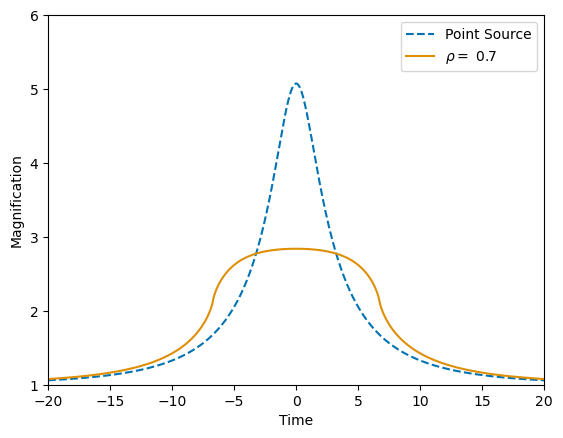

In [6]:
plt.plot(t_arr, A_ps_arr, label=r"Point Source", ls='--')
plt.plot(t_arr, A_fs_arr, label=r"$\rho = $" + ' ' + str(rho))


plt.ylim(1,6)
# plt.ylim(5,50)

plt.xlim(-20,20)
# plt.xlim(-2,2)


plt.xlabel("Time")
plt.ylabel("Magnification")
plt.legend()
# plt.savefig("figures/ps_fs_magnification.pdf")
plt.show()